<center><h1>Snakes and Ladders Game</h1></center>

<img src="snakesladdersimg.jpg" alt="snakes_and_ladders_pic" style="width: 10px; height: 10px;"/>

Snakes and Ladders is a classic multiplayer board game. The board consists 100 squares with numbers and both the snakes and ladders at some of the squares. Player starts from square 0, the goal is to reach the square 100. Each turn, the player roll the dice and move the counter forward according to the number that is shown on the dice. There are some additional rules:
 * If the player lands at the bottom of the ladder, the player will go to the square where the top of the ladder is. 
 * If the player lands at the snake head, the player must go to go to the tail of the snake.
 * If the player lands at the square above 100, the player stays at the current place.

In this notebook, we are interested in approximating the number of steps until finish. There are two methods that we're going to use and compare: **Dynamic Programming** and **Monte Carlo Method**.

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

## 2. Snakes and Ladders Game Implementation

We're going to create a class for the game that imitates the gym environment

### Class Definition

In [2]:
class Dice:
    
    def __init__(self, faces=6):
        
        self.faces = np.arange(1, faces + 1)
    
    def roll(self):
        
        return np.random.choice(self.faces)

In [3]:
class SLEnvironment:
    
    def __init__(self, snakes, ladders, dice, init_state=0, terminal_state=100):
        '''
        Input:
            snakes: dict
                Dictionary of snake heads and tails
            ladders: dict
                Dictionary of bottom and top ladders
            dice: Dice
                Dice object
            init_state: int
                Starting square number
            terminal_state: int
                Winning square number
        '''
        
        self.dice = dice
        self.snakes = snakes
        self.ladders = ladders
        self.init_state = init_state
        self.terminal_state = terminal_state
        self.state_set = list(set(np.arange(101)).difference(set(ladders.keys())).difference(set(snakes.keys())))
        
    def reset(self):
        '''
        Method to reset the game
        Output:
            next_state: int
                next state
            done: bool
                represent if the player reach terminal state
        '''
        self.current_state = self.init_state
        self.history = [self.current_state]
        
        return 0, False
    
    def is_win(self):
        '''
        Method to check if the current state is at the terminal state
        Output:
            is_win: bool
                true if the current state is the terminal state, otherwise false
        '''
        if self.current_state == self.terminal_state:
            return True

        return False
    
    def step(self):
        '''
        Method to take a step in the game. It rolls the dice and moves
        
        Since it doesn't have any action choices, the only interesting variables
        are next state and done.
        
        Output:
            next_state: int
                next state
            done: bool
                represent if the player reach terminal state
        '''
        
        # Get all possible next states
        possible_next_states = self.get_possible_next_state(self.current_state)
        
        # Roll the dice
        dice_roll = self.dice.roll()
        
        # Get next state variable, save it to history
        next_state = possible_next_states[dice_roll-1]
        self.current_state = next_state
        self.history.append(next_state)
        
        # Get done variable
        if self.is_win():
            done = True
        else:
            done = False
            
        return next_state, done
        
        
        
    def get_possible_next_state(self, current_state):
        '''
        Method to get all possible next state. Notice that we use current_state
        argument instead of self.current_state attribute. This is useful for 
        the policy evaluation.
        
        Input:
            current_state: int
        Output:
            next_states: list of int
        '''
        
        # get the next possible states
        next_states = np.arange(1, len(self.dice.faces) + 1) + current_state
        
        # go to the top ladder if the next state land on bottom ladder
        next_states = [self.ladders[state] if state in self.ladders.keys() else state for state in next_states]
        
        # go to the snake tail if the next state land on snake head
        next_states = [self.snakes[state] if state in self.snakes.keys() else state for state in next_states]
        
        # stay in the state if the next state is more than 100
        next_states = [current_state if state > 100 else state for state in next_states]
        
        return next_states

### Instantiation

We're going to use the original 100 squares snakes and ladders game

In [4]:
initial_state = 0
terminal_state = 100

In [5]:
# snakes and ladders data come from the original game
ladders = {
    1: 38,
    4: 14,
    9: 31,
    21: 42,
    28: 84,
    36: 44,
    51: 67,
    71: 91,
    80: 100
}

snakes = {
    16: 6,
    47: 26,
    49: 11,
    56: 53,
    62: 19,
    64: 60,
    87: 24,
    93: 73,
    95: 75,
    98: 78
}

# Stores the non available states such as the bottom of ladder and the head of the snake
non_available_states = set(snakes.keys()).union(set(ladders.keys()))

# Get available states
available_states = list(set(np.arange(initial_state, terminal_state+1)).difference(non_available_states))

In [6]:
dice = Dice(faces=6)
sl_env = SLEnvironment(snakes, ladders, dice, initial_state, terminal_state)

## 3. Policy Evaluation

Dynamic Programming requires a complete knowledge about the environment dynamic. For the snakes and ladders game, the full environment dynamic is known. We are going to use a dynamic programming method called **iterative policy evaluation** method to get the value function. In this problem, we treat the reward $r$ as the step, our desired value is the number of steps required to finish.

The Bellman's equation for solving the value in a state $s$ following policy $\pi$ is : 

$$v(s) = \mathbb{E}_{\pi}[G_{t} | S_{t} = s] = \sum_{a}\pi(a|s)\sum_{s', r}p(s', r | s, a)(r + \gamma v(s'))$$

We want to apply Bellman's equation for the game. First, we define some necessary notaions. Let $S$ be the set of all states, $S_{L}$ be the set of states which at the bottom of the ladder, and $S_{S}$ the set of states which at the head of snake. Suppose also $S' = S - (S_{L} \cup S_{S})$. Then $S'$ contains all the possible next states.

Remarks of applying Bellman's equation for snakes and ladders game : 

 1. The reward $r$ will be $+1$ for all $s \in \mathcal{S}$ and $0$ for the terminal state. This will represents the number of steps to reach 100. Also we specify $\gamma = 1$
 2. There is no action, so we don't consider the policy $\pi$
 3. Probability of landing into state is determined by the dice
 
That being said, we can rewrite Bellman's equation for snakes and ladders as: 

$$v(s) = \sum_{s' \in S'}p(s' | s)(1 + v(s'))$$

with $p(s'|s) = \frac{1}{6}$ for a fair six sided die

### Train the Model

In [7]:
# initialize value
value_set = {i: np.random.randint(low = 1, high = 10) for i in available_states}
value_set[100] = 0

# The epsilon variable represents how accurate we want to be
eps = 0.00000001
while True:
    
    delta = 0
    
    # Iterate for all states (0 to 100)
    for s in available_states:
        
        if s == terminal_state:
            continue
        
        # get the possible next states
        next_states = sl_env.get_possible_next_state(s)
        
        # store the current value of state s
        v = value_set[s]
        
        # update the value using the expected update defined by policy iteration algorithm above
        value_set[s] = np.sum([value_set[state] + 1 for state in next_states]) / len(sl_env.dice.faces)
        
        # calculate the difference between the new value and old value
        delta = np.max([delta, np.abs(v - value_set[s])])
        
    # break if the updated difference is less than epsilon 
    if delta < eps:
        break
        
print("Done!")

Done!


### View Result

In [8]:
# rounding the value function
value_set = {k: v for k, v in value_set.items()}

for i in range(10):
    print(f"Value in state {list(value_set.keys())[i]} is {list(value_set.values())[i]}")
    
print()
for i in range(10, 0, -1):
    print(f"Value in state {list(value_set.keys())[-i]} is {list(value_set.values())[-i]}")

Value in state 0 is 39.225122116448105
Value in state 2 is 39.69640592456476
Value in state 3 is 39.19963957297471
Value in state 5 is 39.2950263250733
Value in state 6 is 39.08728681562757
Value in state 7 is 38.855293058676494
Value in state 8 is 38.60911852279798
Value in state 10 is 38.73419131291309
Value in state 11 is 38.26522683182845
Value in state 12 is 37.840849758439695

Value in state 88 is 17.551762793490777
Value in state 89 is 17.706348704416087
Value in state 90 is 16.717703312773782
Value in state 91 is 15.870292977054476
Value in state 92 is 16.511321536239553
Value in state 94 is 12.093836496173983
Value in state 96 is 10.785830961701484
Value in state 97 is 10.785830961701484
Value in state 99 is 6.000000000000006
Value in state 100 is 0


What this mean is given a current state s, the expected number of steps until finish square is value_set[s]. As an example, if we look at the value of square number 99, it must be equals to 6. This is because the expected number of turns until finish is 6. If we let $X_{99}$ be the number of turns until finish from square 99, then the expectation equation is:

$$
\begin{aligned}
\mathbb{E}[X_{99}] &= \mathbb{E}[X_{99} | \text{dice}=1] p(\text{dice}=1) + \mathbb{E}[X_{99} | \text{dice}\ne1] p(\text{dice}\ne1) \\
&= \frac{1}{6} + (1 + \mathbb{E}[X_{99}]) \frac{5}{6} \\
&= 1 + \frac{5}{6} \mathbb{E}[X_{99}]
\end{aligned}
$$

Solving this equation yields 6, which is our value function at state 99.

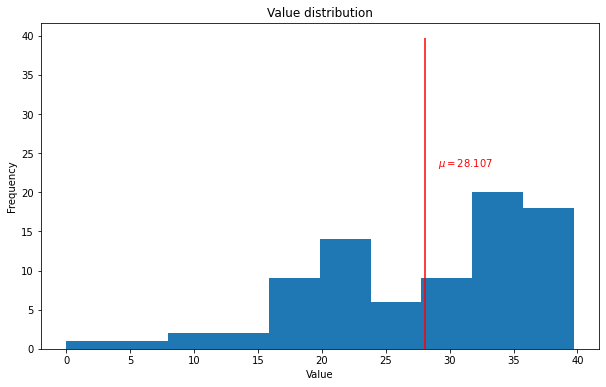

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
_ = plt.hist(value_set.values(), bins=10)
_ = plt.vlines(np.mean(list(value_set.values())), ymin=0, ymax=np.max(list(value_set.values())), colors='red')
_ = plt.text(x=np.mean(list(value_set.values()))+1,
             y=np.max(list(value_set.values()))/1.7,
             s=f"$\mu={round(np.mean(list(value_set.values())), 3)}$",
             color="red")
_ = plt.title("Value distribution")
_ = plt.xlabel("Value")
_ = plt.ylabel("Frequency")

## 4. Comparison with Monte Carlo

The other method to solve the value function is Monte Carlo method. In here, we will compare the required computation until converge.

### Loss Function

Before we head on to the comparison, we need to define the KPI to measure the quality of the estimation. We are going to use mean squared error as our KPI and treat our previous value set as our actual value. The mean squared error is defined as:

$$\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) = \frac{1}{n}(\mathbf{y} - \mathbf{\hat{y}})^{T} (\mathbf{y} - \mathbf{\hat{y}})$$

where $n$ is the number of non terminal states.

In [10]:
def loss(predicted, actual):
    
    '''
    Mean squared Error
    '''
    
    predicted_arr = np.array(list(predicted.values())) 
    actual_arr = np.array(list(actual.values())) 
    
    return np.dot(predicted_arr - actual_arr, predicted_arr - actual_arr) / len(predicted_arr)

### Number of Episodes

In [11]:
n_episode = 500

### Monte Carlo Prediction

The difference between Monte Carlo estimation and Dynamic Programming is that the Monte Carlo doesn't need to know the environment dynamic. Instead, it will learn by experience from playing many games. The value estimation for each non terminal state is the average of steps required until finish.

In [12]:
# Helper function to generate one episode game
def generate_episode(sl_env):
        
    s, done = sl_env.reset()

    while not done:
        s, done = sl_env.step()

    return sl_env.history

In [13]:
# Monte Carlo Prediction
returns_set = {i: 0 for i in available_states}
returns_set[100] = 0
num_visited = {i: 0 for i in available_states}
episode_history_mc = []
operation_history_mc = []

start_time_mc = time.time()
# loop until n_episode
for i in range(n_episode):
    print(f"Episode {i+1}/{n_episode}", end='\r')

    # play one game
    play_history = generate_episode(sl_env)

    # initialize returns
    g = 0

    # loop over from initial state up to before terminal
    for i in range(len(play_history) - 2, -1, -1):

        # increment the return
        g = g + 1

        # check if the current state is visited for the first time
        if play_history[i] not in play_history[:i]:
            
            # increment number of visit
            num_visited[play_history[i]] += 1
            
            # incremental update for average value
            returns_set[play_history[i]] = returns_set[play_history[i]] + (
                (1/num_visited[play_history[i]]) * (g - returns_set[play_history[i]])
            )
            
            # Save the loss for each operation to the history
            operation_history_mc.append(loss(returns_set, value_set))
            
    # Save the loss for each episode to history
    episode_history_mc.append(loss(returns_set, value_set))
    
finish_time_mc = time.time()
time_diff_mc = finish_time_mc - start_time_mc
print(f"Total time spent on {n_episode} episodes: {round(time_diff_mc, 3)} seconds")

Total time spent on 500 episodes: 0.716 seconds


### Policy Evaluation

Next, we are going to re-do our policy evaluation algorithm. This time, we will also record the loss between the estimation and the actual value (value set).

In [14]:
returns_set = {i: 0 for i in available_states}
returns_set[100] = 0
episode_history_pe = []
operation_history_pe = []

start_time_pe = time.time()
# loop until n_episode
for i in range(n_episode):
    print(f"Episode {i+1}/{n_episode}", end='\r')

    # Iterate for all states (0 to 100)
    for s in available_states:

        if s == terminal_state:
            continue

        # get the possible next states
        next_states = sl_env.get_possible_next_state(s)

        # update the value using the expected update defined by policy iteration algorithm above
        returns_set[s] = np.sum([returns_set[state] + 1 for state in next_states]) / len(sl_env.dice.faces)
        
        # Save the loss for each operation to the history
        operation_history_pe.append(loss(returns_set, value_set))

    # Save the loss for each episode to the history
    episode_history_pe.append(loss(returns_set, value_set))
    
finish_time_pe = time.time()
time_diff_pe = finish_time_pe - start_time_pe
print(f"Total time spent on {n_episode} episodes: {round(time_diff_pe, 3)} seconds")

Total time spent on 500 episodes: 1.249 seconds


For iterating over the same number of episodes, the Monte Carlo method is significantly faster. This is because the Monte Carlo doesn't need to go to all possible states. Let's view the result by making a plot!

### Plot Results

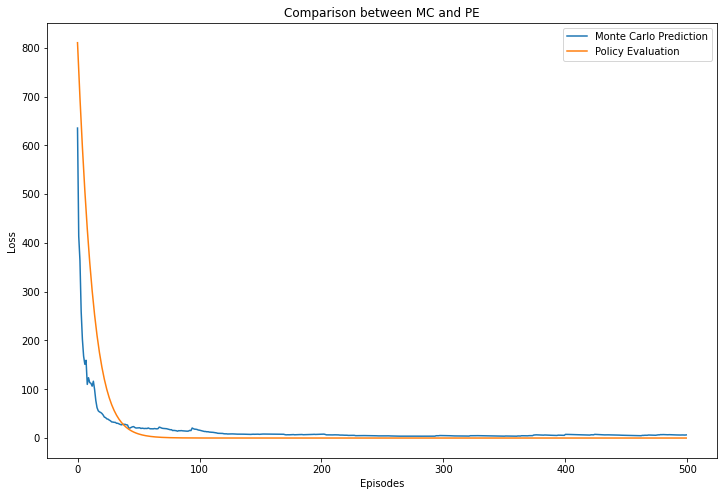

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = plt.plot(episode_history_mc, label="Monte Carlo Prediction")
_ = plt.plot(episode_history_pe, label="Policy Evaluation")
_ = plt.legend()
_ = plt.title("Comparison between MC and PE")
_ = plt.ylabel("Loss")
_ = plt.xlabel("Episodes")

At first, the Monte Carlo method has significantly lower loss than Policy Evaluation. But as they play more than 100 games, the Policy Evaluation gives the better prediction. This is because the Policy Evaluation method iterates over all states whereas Monte Carlo doesn't. To make it more fair, let's make another plot of loss and the number of updates.

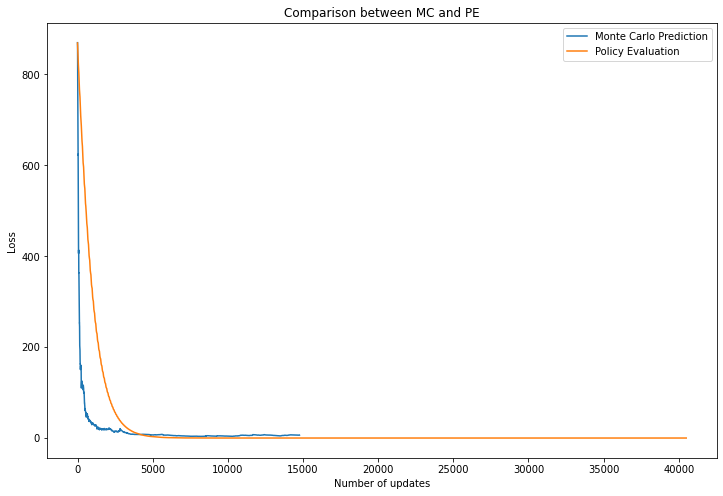

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = plt.plot(operation_history_mc, label="Monte Carlo Prediction")
_ = plt.plot(operation_history_pe, label="Policy Evaluation")
_ = plt.legend()
_ = plt.title("Comparison between MC and PE")
_ = plt.ylabel("Loss")
_ = plt.xlabel("Number of updates")

Again, Monte Carlo has a faster convergence rate during few thousand of updates, this method will be preferable if we need to estimate the value as soon as possible. 

## 5. Monte Carlo with Exploring Starts

There's another variant of Monte Carlo method which is the exploring start. The way that it works is by generating an episode that starts from a random state (instead of initial_state) uniformly. At first glance, this method seems desirable because we will be updating the value of states that are rarely visited by the original Monte Carlo method. Below is the implementation:

In [17]:
# Helper function to generate one episode game from random state
def generate_episode_es(sl_env, available_state):

    s, done = sl_env.reset()
    
    # remove the initial state
    sl_env.history.pop(sl_env.init_state)
    
    # start from the random state
    s = np.random.choice(available_state)
    sl_env.current_state = s
    sl_env.history.append(s)
    done = sl_env.is_win()

    while not done:
        s, done = sl_env.step()

    return sl_env.history

In [18]:
# Monte Carlo Prediction
returns_set = {i: 0 for i in available_states}
returns_set[100] = 0
num_visited = {i: 0 for i in available_states}
episode_history_mc_es = []
operation_history_mc_es = []

start_time_mc_es = time.time()
# loop until n_episode
for i in range(n_episode):
    print(f"Episode {i+1}/{n_episode}", end='\r')

    # play one game
    play_history = generate_episode_es(sl_env, available_states)

    # initialize returns
    g = 0

    # loop over from initial state up to before terminal
    for i in range(len(play_history) - 2, -1, -1):

        # increment the return
        g = g + 1

        # check if the current state is visited for the first time
        if play_history[i] not in play_history[:i]:
            
            # increment number of visit
            num_visited[play_history[i]] += 1
            
            # incremental update for average value
            returns_set[play_history[i]] = returns_set[play_history[i]] + (
                (1/num_visited[play_history[i]]) * (g - returns_set[play_history[i]])
            )
            
            # Save the loss for each operation to the history
            operation_history_mc_es.append(loss(returns_set, value_set))
            
    # Save the loss for each episode to history
    episode_history_mc_es.append(loss(returns_set, value_set))
    
finish_time_mc_es = time.time()
time_diff_mc_es = finish_time_mc_es - start_time_mc_es
print(f"Total time spent on {n_episode} episodes: {round(time_diff_mc_es, 3)} seconds")

Total time spent on 500 episodes: 0.434 seconds


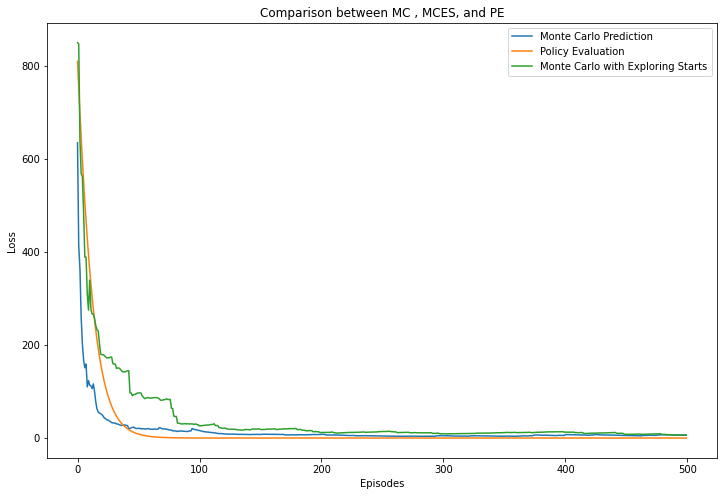

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = plt.plot(episode_history_mc, label="Monte Carlo Prediction")
_ = plt.plot(episode_history_pe, label="Policy Evaluation")
_ = plt.plot(episode_history_mc_es, label="Monte Carlo with Exploring Starts")
_ = plt.legend()
_ = plt.title("Comparison between MC , MCES, and PE")
_ = plt.ylabel("Loss")
_ = plt.xlabel("Episodes")

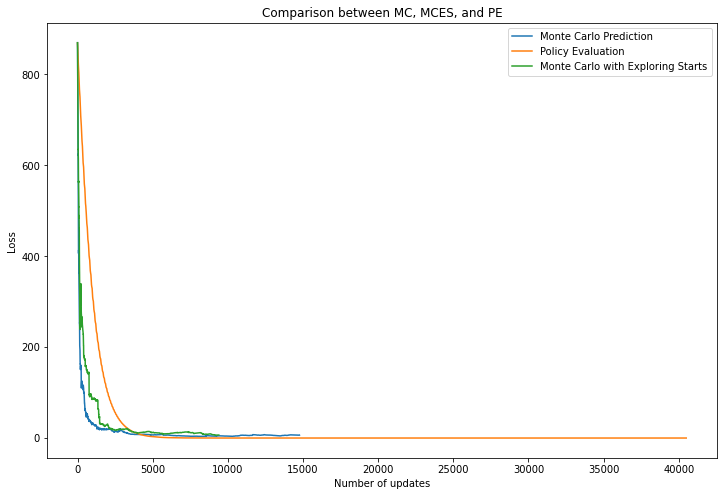

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = plt.plot(operation_history_mc, label="Monte Carlo Prediction")
_ = plt.plot(operation_history_pe, label="Policy Evaluation")
_ = plt.plot(operation_history_mc_es, label="Monte Carlo with Exploring Starts")
_ = plt.legend()
_ = plt.title("Comparison between MC, MCES, and PE")
_ = plt.ylabel("Loss")
_ = plt.xlabel("Number of updates")

Since the snakes and ladders game starts at initial state 0, the exploring starts method doesn't produce a great result compares to the original Monte Carlo method. The reason is there are some states in the actual game that are rarely visited but are visited frequently as the result of exploring starts.

## 5. Conclusion

Both Dynamic Programming and Monte Carlo method are used to solve the reinforcement learning problems. Dynammic programming is preferable if we know the environment dynamics and the state space is finite and small. Most real world problems have large or infinite state space, in this case Monte Carlo Methods are desirable. It is also faster to converge than Dynamic Programming